This notebook implements the Dice2016R2 model in Python. It is based on :
- The PyOmo library (http://www.pyomo.org/)
- The ipopt solver (https://coin-or.github.io/Ipopt/)
- A former implementation of Dice 2013 (https://github.com/moptimization/pythondice2013implementation)

See the Gams code of the model on the Nordhaus' webpage : https://sites.google.com/site/williamdnordhaus/dice-rice

In [1]:
import pandas as pd
import numpy as np

In [2]:
import pyomo.environ as pe
import pyomo.opt as po

In [3]:
import matplotlib.pyplot as plt

## Parameters of the Dice model

### Main parameters of the model are stored in the file Dice2016R2Parameters.csv

In [4]:
paramDF = pd.read_csv('Dice2016R2Parameters.csv')
params = dict(zip(paramDF.key,paramDF.value))

In [5]:
paramDF.head()

,key,value,description
0,numPeriods,100.00,The number of periods
1,fosslim,6000.00,Maximum cumulative extraction fossil fuels (GtC)
2,tstep,5.00,Years per period
3,ifopt,0.00,Indicator where optimized is 1 and base is 0
4,elasmu,1.45,Elasticity of marginal utility of consumption


### Further definitions of parameters

Carbon cycle transition matrix

In [6]:
params["b11"] = 1 - params["b12"]
params["b21"] = params["b12"] * params["mateq"] / params["mueq"]
params["b22"] = 1 - params["b21"] - params["b23"]
params["b32"] = params["b23"] * params["mueq"] / params["mleq"]
params["b33"] = 1 - params["b32"]

In [7]:
params["a20"] = params["a2"] # to store the damage parameter for different scenarios

In [8]:
params["sig0"] = params["e0"] /  (params["q0"] * (1 - params["miu0"])) # Carbon intensity in 2010
params["lam"] = params["fco22x"] / params["t2xco2"]     # Climate model parameter
params["optlrsav"] = (params["dk"] + 0.004) / (params["dk"] + 0.004 * params["elasmu"] + params["prstp"]) * params["gama"]   # Optimal long-run savings rate used for transversality

Initial value for cumulative carbon emissions

In [9]:
params["cca0"] = 400.0

In [10]:
params["numPeriods"] = int(params["numPeriods"]) # to have the right type

## Time-dependent parameters and exogenous variables (Python dictionaries)

### Trajectories of exogenous variables

Computation of the trajectory of population

In [11]:
def getPopulation(maxPeriods,pop0,popasym,popadj):
    """
    Projected population (l)
    
    pop0 : initial population (in millions)
    popasym : asymptotic population (in millions)
    popadj : growth rate to calibrate to 2050 pop projection
    
    Gams code : loop(t, l(t+1)=l(t)*(popasym/L(t))**popadj ;);
    """
    population = {}
    population[1] = pop0

    for t in range(2,maxPeriods +1):
        population[t] = population[t-1]*(popasym/population[t-1])**popadj

    return population

Computation of the growth rate of productivity

In [12]:
def getGrowthRateOfProductivity(ga0,dela,numPeriods,tstep):
    """
    Growth rate of productivity (ga)
    
    ga0 : initial growth rate for TFP per period
    dela : decline rate of TFP per period
    tstep : duration of a period ( = 5 years)
    
    Gams code : ga(t)=ga0*exp(-dela*5*((t.val-1)));
    """
    productivityGR = {} 

    for t in range(numPeriods):
        productivityGR[t+1] = ga0 * np.exp(-dela*tstep*t)

    return productivityGR

Computation of the level of total factor productivity

In [13]:
def getLevelOfProductivity(a0,ga,numPeriods):
    """
    Level of total factor productivity (al)

    a0 : initial level of TFP
    ga : growth rate of productivity

    Gams code : loop(t, al(t+1)=al(t)/((1-ga(t))););
    """
    productivity = {}
    productivity[1] = a0
    
    for t in range(2,numPeriods +1):
        productivity[t] = productivity[t-1]/(1-ga[t-1])
    
    return productivity

Computation of the cumulative efficiency improvement

In [14]:
def getCumulativeEfficiencyImprovement(gsigma1,dsig,tstep,numPeriods):
    """
    Change in sigma (cumulative improvement of energy efficiency)
    gsigma1 : initial growth of sigma (per year)
    dsig : decline rate of decarbonization (per period)
    tstep : duration of a period (= 5 years)
    
    Gams code : loop(t,gsig(t+1)=gsig(t)*((1+dsig)**tstep) ;);
    """
    efficiency = {}
    efficiency[1] = gsigma1
    for t in range(2,numPeriods +1):
        efficiency[t] = efficiency[t-1]*((1+dsig)**tstep)
    
    return efficiency

Computation of the output ratio of C02 equivalent emissions

In [15]:
def getGrowthRate(sig0,gsig,tstep,numPeriods):
    """
    CO2-equivalent-emissions output ratio (sigma)
    
    sig0 : Carbon intensity 2010
    gsig : cumulative improvement of energy efficiency (change in sigma)
    tstep : duration of a period (= 5 years)
    
    Gams code :  loop(t,sigma(t+1)=(sigma(t)*exp(gsig(t)*tstep)););
    """
    growthRate = {}
    growthRate[1] = sig0
    
    for t in range(2,numPeriods +1):
        growthRate[t] = growthRate[t-1]*np.exp(gsig[t-1]*tstep)
        
    return growthRate

Computation of backstop price

In [16]:
def getBackstopPrice(pback,gback,numPeriods):
    """
    Backstop price (pbacktime)
    
    pback : cost of backstop 2010$ per tC02
    gback : initial cost decline backstop cost per period
    
    Gams code : pbacktime(t)=pback*(1-gback)**(t.val-1);
    """
    backstopPrice = {}

    for t in range(numPeriods):
        backstopPrice[t+1] = pback*(1-gback)**t

    return backstopPrice

Computation of adjusted cost for backstop

In [17]:
def getAdjustedCostForBackstop(pbacktime,sigma,expcost2,numPeriods):
    """
    Adjusted cost for backstop (cost1)
    
    pbacktime : backstop price
    sigma : GHG output ratio
    expcost2 : exponent of control cost function
    
    Gams code : cost1(t) = pbacktime(t)*sigma(t)/expcost2/1000;
    """
    adjCost = {}
    
    for t in range(1,numPeriods +1):
        adjCost[t] = pbacktime[t] * sigma[t] / expcost2 / 1000
    
    return adjCost

Computation of emissions from deforestation

In [18]:
def getEmissionsFromDeforestation(eland0,deland,numPeriods):
    """
    Emissions from deforestation (etree)
    
    eland0 : Carbon emissions from land 2015
    deland : decline rate of land emissions per period
    
    Gams code : etree(t) = eland0*(1-deland)**(t.val-1);
    """
    emissions = {}
    
    for t in range(1,numPeriods +1):
        emissions[t] = eland0 * (1 - deland)**(t-1)
    
    return emissions

Computation of cumulative emissions from land

In [19]:
def getCumulativeEmissionsFromLand(etree,numPeriods):
    """
    Cumulative from land (cumetree)
    
    etree : emissions from deforestation
    
    Gams code : loop(t,cumetree(t+1)=cumetree(t)+etree(t)*(5/3.666);)
    """
    cumulatem = {}
    cumulatem[1] = 100.0 
    
    for t in range(2,numPeriods +1) :
        cumulatem[t] = cumulatem[t-1] + etree[t-1]*(5/3.666)
    
    return cumulatem

Computation of average utility social discount rate

In [20]:
def getAverageUtilitySocialDiscountRate(prstp,tstep,numPeriods):
    """
    Average utility social discount rate (rr)
    
    prstp : Initial rate of social time preference per year
    tstep : duration of a period
    
    Gams code : rr(t) = 1/((1+prstp)**(tstep*(t.val-1)));
    """
    utilDisc = {}
    
    for t in range(1,numPeriods +1):
        utilDisc[t] = 1./((1+prstp)**(tstep*(t-1)))
    
    return utilDisc

Computation of Exogenous forcing for other greenhouse gases (with interpolation between 2015 and 2100)

In [21]:
def getExogenousForcingOfOtherGreenhouseGases(fex0,fex1,numPeriods):
    """
    Exogenous forcing for other greenhouse gases (forcoth)
    
    fex0 : 2015 forcings of non CO2 GHG
    fex1 : 2100 forcings of non CO2 GHG
    
    Gams code : forcoth(t) = fex0+ (1/17)*(fex1-fex0)*(t.val-1)$(t.val lt 18)+ (fex1-fex0)$(t.val ge 18);
    """
    exogForcing = {}
    
    for t in range(1,numPeriods +1):
        if t < 18:
            exogForcing[t] = fex0 + (1./17.)*(fex1-fex0)*(t-1)
        else:
            exogForcing[t] = fex1
            
    return exogForcing

Computation of carbon price in base case

In [22]:
def getCarbonPrice(cprice0,gcprice,tstep,numPeriods):
    """
    Base Case Carbon Price (cpricebase)
    
    cprice0 : initial base carbon price
    gcprice : growth rate of base carbon price per year
    tstep : duration of a period
    
    Gams code : cpricebase(t)= cprice0*(1+gcprice)**(5*(t.val-1));
    """
    carbonPrice = {}
    
    for t in range(1,int(numPeriods)+1):
        carbonPrice[t] = cprice0*(1+gcprice)**(tstep*(t-1))

    return carbonPrice

In [23]:
# computation of the exogenous variables

params['l'] = getPopulation(params['numPeriods'],params['pop0'],params['popasym'],params['popadj']) 

params['ga'] = getGrowthRateOfProductivity(params['ga0'],params['dela'],params['numPeriods'],params['tstep'])

params['al'] = getLevelOfProductivity(params['a0'],params['ga'],params['numPeriods'])

params['gsig'] = getCumulativeEfficiencyImprovement(params['gsigma1'],params['dsig'],params['tstep'],params['numPeriods'])

params['sigma'] = getGrowthRate(params['sig0'],params['gsig'],params['tstep'],params['numPeriods'])

params['pbacktime'] = getBackstopPrice(params['pback'],params['gback'],params['numPeriods'])

params['cost1'] = getAdjustedCostForBackstop(params['pbacktime'],params['sigma'],params['expcost2'],params['numPeriods'])

params['etree'] = getEmissionsFromDeforestation(params['eland0'],params['deland'],params['numPeriods'])

params['cumetree'] = getCumulativeEmissionsFromLand(params['etree'], params['numPeriods'])

params['rr'] = getAverageUtilitySocialDiscountRate(params['prstp'],params['tstep'],params['numPeriods'])

params['forcoth'] = getExogenousForcingOfOtherGreenhouseGases(params['fex0'],params['fex1'],params['numPeriods'])

params['cpricebase'] = getCarbonPrice(params['cprice0'],params['gcprice'],params['tstep'],params['numPeriods'])


In [24]:
# photel(t)     Carbon Price under no damages (Hotelling rent condition)

Indicator where optimized is 1 and base is 0.

In [25]:
params["ifopt"]

0.0

### All the parameters are now set up.

## Definition of an instance of the model

In [26]:
def diceModel2016(**kwargs):
    
    model = pe.ConcreteModel("Dice2016R") # Dice2016 is a PyOmo concrete model
    
    ###SETS AND INDICES###
    model.time_periods = pe.Set( initialize=kwargs['rr'].keys()) # t = 1 .. numPeriods
    
    ###VARIABLES### 
    
    ## Boundaries
    
    # Control rate limit
    def miuBounds(model,t):
        if (t == 1) and (kwargs['ifopt'] == 1):    # if optimal control on emissions
            return (kwargs['miu0'],kwargs['miu0']) # initial value
        elif t < 30:
            return (0.,1.)
        else:
            return (0.,kwargs['limmiu']) # upper limit on control rate after 2150

        
    # upper and lower bounds for stability    
    def tatmBounds(model,t):
        if t == 1: 
            return (kwargs['tatm0'],kwargs['tatm0'])  # initial value
        else:
            return (0.,20.)  # range for increase temperature in atmosphere

    def toceanBounds(model,t):
        if t == 1: 
            return (kwargs['tocean0'],kwargs['tocean0']) # initial value
        else:
            return (-1.,20.) # range for increase temperature in oceans

    def matBounds(model,t):
        if t == 1: 
            return (kwargs['mat0'],kwargs['mat0']) # initial value
        else:
            return (10.,np.inf) # range for carbon concentration increase in atmosphere

    def muBounds(model,t):
        if t == 1: 
            return (kwargs['mu0'],kwargs['mu0']) # initial value
        else:
            return (100.,np.inf) # range for carbon concentration increase in shallow oceans

    def mlBounds(model,t):
        if t == 1: 
            return (kwargs['ml0'],kwargs['ml0'])  # initial value
        else:
            return (1000.,np.inf) # range for carbon concentration in lower oceans

    def cBounds(model,t):
        return (2.,np.inf) # lower bound for consumption

    def kBounds(model,t):
        if t == 1: 
            return (kwargs['k0'],kwargs['k0']) # initial value
        else:
            return (1.,np.inf) # lower bound for capital stock

    def cpcBounds(model,t):
        return (.01,np.inf) # lower bound for per capita consumption

    # control variable
    def sBounds(model,t):
        if t <= kwargs['numPeriods'] - 10:
            return (-np.inf,np.inf)
        else:
            return (kwargs['optlrsav'],kwargs['optlrsav']) # constraint saving rate at the end 

    # Ressource limit
    def ccaBounds(model,t):
        if t == 1:
            return (kwargs['cca0'],kwargs['cca0']) # initial value
        else:
            return (-np.inf,kwargs['fosslim']) # maximum cumulative extraction fossil fuels

    ## Declarations    
        
    #Emission control rate GHGs    
    model.MIU = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=miuBounds) 
    
    # Increase in radiative forcing (watts per m2 from 1900)
    model.FORC = pe.Var(model.time_periods,domain=pe.Reals) 
    
    # Increase temperature of atmosphere (degrees C from 1900)
    model.TATM = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=tatmBounds) 
    
    # Increase temperatureof lower oceans (degrees C from 1900)
    model.TOCEAN = pe.Var(model.time_periods,domain=pe.Reals,bounds=toceanBounds) 

    # Carbon concentration increase in atmosphere (GtC from 1750)
    model.MAT = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=matBounds) 

    # Carbon concentration increase in shallow oceans (GtC from 1750)
    model.MU = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=muBounds) 

    # Carbon concentration increase in lower oceans (GtC from 1750)
    model.ML = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=mlBounds) 

    # Total CO2 emissions (GtCO2 per year)
    model.E = pe.Var(model.time_periods,domain=pe.Reals) 
    
    #Industrial emissions (GtCO2 per year)
    model.EIND = pe.Var(model.time_periods,domain=pe.Reals) 

    # Consumption (trillions 2005 US dollars per year)
    model.C = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=cBounds) 

    # Capital stock (trillions 2005 US dollars)
    model.K = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=kBounds) 

    # Per capita consumption (thousands 2005 USD per year)
    model.CPC = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=cpcBounds) 

    # Investment (trillions 2005 USD per year)
    model.I = pe.Var(model.time_periods,domain=pe.NonNegativeReals) 

    # Gross savings rate as fraction of gross world product
    model.S = pe.Var(model.time_periods,domain=pe.Reals,bounds=sBounds) 

    # Real interest rate (per annum)
    model.RI = pe.Var(model.time_periods,domain=pe.Reals) 

    # Gross world product net of abatement and damages (trillions 2005 USD per year)
    model.Y = pe.Var(model.time_periods,domain=pe.NonNegativeReals) 

    # Gross world product GROSS of abatement and damages (trillions 2005 USD per year)
    model.YGROSS = pe.Var(model.time_periods,domain=pe.NonNegativeReals) 

    # Output net of damages equation (trillions 2005 USD per year)
    model.YNET = pe.Var(model.time_periods,domain=pe.Reals) 

    # Damages (trillions 2005 USD per year)
    model.DAMAGES = pe.Var(model.time_periods,domain=pe.Reals) 

    # Damages as fraction of gross output
    model.DAMFRAC = pe.Var(model.time_periods,domain=pe.Reals) 

    # Cost of emissions reductions  (trillions 2005 USD per year)
    model.ABATECOST = pe.Var(model.time_periods,domain=pe.Reals) 

    # Marginal cost of abatement (2005$ per ton CO2)
    model.MCABATE = pe.Var(model.time_periods,domain=pe.Reals) 

    # Cumulative industrial carbon emissions (GTC)
    model.CCA = pe.Var(model.time_periods,domain=pe.Reals,bounds=ccaBounds) 
    
    # Total carbon emissions (GtC)
    model.CCATOT = pe.Var(model.time_periods,domain=pe.Reals)

    # One period utility function
    model.PERIODU = pe.Var(model.time_periods,domain=pe.Reals) 

    # Carbon price (2005$ per ton of CO2) !!! No initial upper bound in version 2016R
    model.CPRICE = pe.Var(model.time_periods,domain=pe.Reals) 

    # Period utility
    model.CEMUTOTPER = pe.Var(model.time_periods,domain=pe.Reals) 

    # Welfare function
    model.UTILITY = pe.Var(domain=pe.Reals) 

    ### Equations
    
    ## Emissions and damages

    # eeq(t)
    def emissionsEquation(model,t):
        return (model.E[t] == model.EIND[t] + kwargs['etree'][t])
    
    model.emissionsEquation = pe.Constraint(model.time_periods,rule=emissionsEquation)

    # eindeq(t)
    def industrialEmissions(model,t): 
        # EIND(t) =E= sigma(t) * YGROSS(t) * (1-(MIU(t)));
        return (model.EIND[t] == kwargs['sigma'][t] * model.YGROSS[t] * (1 - model.MIU[t]))

    model.industrialEmissions = pe.Constraint(model.time_periods,rule=industrialEmissions)

    # ccacca(t+1)
    def cumCarbonEmissions(model,t):
        if t == 1:
            return pe.Constraint.Skip # to use boundary value instead of  constraint
        else:
            return (model.CCA[t] == model.CCA[t-1] + model.EIND[t-1] * kwargs['tstep'] / 3.666)

    model.cumCarbonEmissions = pe.Constraint(model.time_periods,rule=cumCarbonEmissions)

    # ccatoteq(t)
    def totCarbonEmissions(model,t):
        return (model.CCATOT[t] == model.CCA[t] + kwargs['cumetree'][t])
    
    model.totCarbonEmissions = pe.Constraint(model.time_periods,rule=totCarbonEmissions)
    
    # force(t)
    def radiativeForcing(model,t): 
        return (model.FORC[t] == kwargs['fco22x'] * (pe.log10(model.MAT[t]/588.0)/pe.log10(2)) + kwargs['forcoth'][t])

    model.radiativeForcing = pe.Constraint(model.time_periods,rule=radiativeForcing)

    # damfraceq(t)
    def damageFraction(model,t):
        return (model.DAMFRAC[t] == (kwargs['a1'] * model.TATM[t]) + (kwargs['a2'] * model.TATM[t]**kwargs['a3']))

    model.damageFraction = pe.Constraint(model.time_periods,rule=damageFraction)

    # dameq(t)
    def damagesConst(model,t):
        return (model.DAMAGES[t] == (model.YGROSS[t] * model.DAMFRAC[t]))

    model.damagesConst = pe.Constraint(model.time_periods,rule=damagesConst)

    # abateeq(t)
    def abatementCost(model,t):
        return (model.ABATECOST[t] == model.YGROSS[t] * kwargs['cost1'][t] * (model.MIU[t]**kwargs['expcost2']))

    model.abatementCost = pe.Constraint(model.time_periods,rule=abatementCost)

    # mcabateeq(t)
    def mcAbatement(model,t): 
  
        myExp = kwargs['expcost2'] - 1
        return (model.MCABATE[t] == kwargs['pbacktime'][t] * (model.MIU[t])**myExp)
          
    model.mcAbatement = pe.Constraint(model.time_periods,rule=mcAbatement)

    # carbpriceeq(t)            
    def carbonPriceEq(model,t): 
        myExp = kwargs['expcost2'] - 1
        return (model.CPRICE[t] == kwargs['pbacktime'][t] * (model.MIU[t])**myExp)

    model.carbonPriceEq = pe.Constraint(model.time_periods,rule=carbonPriceEq)

    ## Climate and carbon cycle
                
    # mmat(t+1)
    def atmosphericConcentration(model,t):
        if t == 1:
            return pe.Constraint.Skip
        else: 
            #MAT(t+1)       =E= MAT(t)*b11 + MU(t)*b21 + (E(t)*(tstep/3.666));
            return (model.MAT[t] == model.MAT[t-1]*kwargs['b11'] + model.MU[t-1] * kwargs['b21'] + model.E[t-1] * kwargs['tstep'] / 3.666)

    model.atmosphericConcentration = pe.Constraint(model.time_periods,rule=atmosphericConcentration)

    # mml(t+1)            
    def lowerOceanConcentration(model,t):
        if t == 1:
            return pe.Constraint.Skip
        else:
            return (model.ML[t] == model.ML[t-1]*kwargs['b33'] + model.MU[t-1] * kwargs['b23'] )

    model.lowerOceanConcentration = pe.Constraint(model.time_periods,rule=lowerOceanConcentration)

    # mmu(t+1)
    def upperOceanConcentration(model,t):
        if t == 1:
            return pe.Constraint.Skip
        else:
            return (model.MU[t] == model.ML[t-1]*kwargs['b32'] + model.MU[t-1] * kwargs['b22'] + model.MAT[t-1] * kwargs['b12'])

    model.upperOceanConcentration = pe.Constraint(model.time_periods,rule=upperOceanConcentration)

    # tatmeq(t+1)
    def atmosphericTemperature(model,t):
        if t == 1:
            return pe.Constraint.Skip
        else: 
            return (model.TATM[t] == model.TATM[t-1] + kwargs['c1'] * ((model.FORC[t] - (kwargs['fco22x']/kwargs['t2xco2'])*model.TATM[t-1]) \
                                                                       - (kwargs['c3'] * (model.TATM[t-1] - model.TOCEAN[t-1]))))

    model.atmosphericTemperature = pe.Constraint(model.time_periods,rule=atmosphericTemperature)

    # toceaneq(t+1)            
    def oceanTemperature(model,t):
        if t == 1:
            return pe.Constraint.Skip
        else:
            return (model.TOCEAN[t] == model.TOCEAN[t-1] + kwargs['c4'] * (model.TATM[t-1] - model.TOCEAN[t-1]))

    model.oceanTemperature = pe.Constraint(model.time_periods,rule=oceanTemperature)

    ## Economic variables            
    
    # ygrosseq(t)
    def grossOutput(model,t):
        # YGROSS(t) =E= (al(t)*(L(t)/1000)**(1-GAMA))*(K(t)**GAMA);
        coeff = kwargs['al'][t]*(kwargs['l'][t]/1000)**(1-kwargs['gama'])
        return (model.YGROSS[t] == coeff*(model.K[t]**kwargs['gama']))

    model.grossOutput = pe.Constraint(model.time_periods,rule=grossOutput)

    # yneteq(t)
    def netOutput(model,t):
        return (model.YNET[t] == model.YGROSS[t] * (1-model.DAMFRAC[t]))

    model.netOutput = pe.Constraint(model.time_periods,rule=netOutput)

    # yy(t)
    def outputNetEqn(model,t):
        return (model.Y[t] == model.YNET[t] - model.ABATECOST[t])

    model.outputNetEqn = pe.Constraint(model.time_periods,rule=outputNetEqn)

    # cc(t)
    def consumptionEqn(model,t):
        return (model.C[t] == model.Y[t] - model.I[t])

    model.consumptionEqn = pe.Constraint(model.time_periods,rule=consumptionEqn)


    # cpce(t)
    def perCapitaConsumption(model,t):
        return (model.CPC[t] == 1000 * model.C[t] / kwargs['l'][t])
                
    model.perCapitaConsumption = pe.Constraint(model.time_periods,rule=perCapitaConsumption)

    # seq(t)
    def savingsRate(model,t):
        return (model.I[t] ==  model.S[t] * model.Y[t])
                
    model.savingsRate = pe.Constraint(model.time_periods,rule=savingsRate)

    # kk(t+1)
    def capitalBalance(model,t):
        if t == 1:
            return pe.Constraint.Skip # initial value defined by the boundary
        else: 
            #K(t+1)   =L= (1-dk)**tstep * K(t) + tstep * I(t);
            return (model.K[t] == (1 - kwargs['dk'])**kwargs['tstep'] * model.K[t-1] + kwargs['tstep'] * model.I[t-1])

    model.capitalBalance = pe.Constraint(model.time_periods,rule=capitalBalance)

    # rieq(t)             
    def interestRateEqn(model,t):
        if t == 1:
            return pe.Constraint.Skip # initial value defined by the boundary
        else:
            return (model.RI[t] == (1 + kwargs['prstp']) * (model.CPC[t]/model.CPC[t-1])** (kwargs['elasmu']/kwargs['tstep']) - 1)

    model.interestRateEqn = pe.Constraint(model.time_periods,rule=interestRateEqn)

    # cemutotpereq(t)
    def periodUtilityEqn(model,t):
        return (model.CEMUTOTPER[t] ==  model.PERIODU[t] * kwargs['l'][t] * kwargs['rr'][t])

    model.periodUtilityEqn = pe.Constraint(model.time_periods,rule=periodUtilityEqn)

    # periodueq(t)
    def instUtilityEqn(model,t):
        return (model.PERIODU[t] ==  ((model.C[t] * 1000 / kwargs['l'][t])**(1-kwargs['elasmu'])-1) / (1-kwargs['elasmu']) - 1)
    
    model.instUtilityEqn = pe.Constraint(model.time_periods,rule=instUtilityEqn)

    # util 
    def utilityCalc(model):
        return (model.UTILITY == kwargs['tstep'] * kwargs['scale1'] * pe.summation(model.CEMUTOTPER) + kwargs['scale2'])

    model.utilityCalc = pe.Constraint(rule=utilityCalc)

    ### objective function
    
    def obj_rule(model):
        return  model.UTILITY
                
    model.OBJ = pe.Objective(rule=obj_rule, sense=pe.maximize)

    return model

The model can be built now.

In [27]:
dicemodel = diceModel2016(**params)

In [28]:
dicemodel.getname()

'Dice2016R'

## Data handling

In [38]:
# df_results = pd.DataFrame(index = sorted(params["l"].keys())) # create a pandas dataframe to store the results

In [29]:
def createColumn(variableName,variable,df):
    """
    Put the result of a simulation in a pandas dataframe
    """
    temp = variable.extract_values()
    df[variableName] = 0.0
    for key,value in temp.items() :
        df[variableName][key] = value
    return

## Solving the model

Declaration of the solver (ipopt)

In [30]:
solver = po.SolverFactory('ipopt')

Scenario : base = 0 /optimized = 1

- In the baseline scenario, carbon price is the maximum of Hotelling rent or baseline price.
- In the optimized scenario, ...

In [32]:
# case ifopt = 0
params["ifopt"] = 0

In [34]:
# first solve (without damage function)

df_results0 = pd.DataFrame(index = sorted(params["l"].keys())) # create a pandas dataframe to store the results

params["a2"] = 0.0 # baseline run : no damage due to GHG
        
dicemodel0 = diceModel2016(**params) # model setup
        
results0 = solver.solve(dicemodel0) # solve the model without damage function
    
# Sanity check
if (results0.solver.status != po.SolverStatus.ok):
    print('Check solver not ok ?')
if (results0.solver.termination_condition != po.TerminationCondition.optimal):  
    print('Check solver optimality ?')

#  Value of the utility function for the solution
print('Optimal solution value for intermediate computation :', dicemodel0.OBJ())

# Hotelling price
createColumn('PHOTEL',dicemodel0.CPRICE,df_results0)

params["a2"] = params["a20"] # restore the damage parameter

Optimal solution value for intermediate computation : 4620.353570085999


In [35]:

# store the results
createColumn('MIU',dicemodel0.MIU,df_results0)
createColumn('FORC',dicemodel0.FORC,df_results0)
createColumn('TATM',dicemodel0.TATM,df_results0)
createColumn('TOCEAN',dicemodel0.TOCEAN,df_results0)
createColumn('MAT',dicemodel0.MAT,df_results0)
createColumn('MU',dicemodel0.MU,df_results0)
createColumn('ML',dicemodel0.ML,df_results0)
createColumn('E',dicemodel0.E,df_results0)
createColumn('EIND',dicemodel0.EIND,df_results0)
createColumn('C',dicemodel0.C,df_results0)
createColumn('K',dicemodel0.K,df_results0)
createColumn('CPC',dicemodel0.CPC,df_results0)
createColumn('I',dicemodel0.I,df_results0)
createColumn('S',dicemodel0.S,df_results0)
createColumn('RI',dicemodel0.RI,df_results0)
createColumn('Y',dicemodel0.Y,df_results0)
createColumn('YGROSS',dicemodel0.YGROSS,df_results0)
createColumn('YNET',dicemodel0.YNET,df_results0)
createColumn('DAMAGES',dicemodel0.DAMAGES,df_results0)
createColumn('DAMFRAC',dicemodel0.DAMFRAC,df_results0)
createColumn('ABATECOST',dicemodel0.ABATECOST,df_results0)
createColumn('MCABATE',dicemodel0.MCABATE,df_results0)
createColumn('CCA',dicemodel0.CCA,df_results0)
createColumn('CCATOT',dicemodel0.CCATOT,df_results0)
createColumn('PERIODU',dicemodel0.PERIODU,df_results0)
createColumn('CPRICE',dicemodel0.CPRICE,df_results0)
createColumn('CEMUTOTPER',dicemodel0.CEMUTOTPER,df_results0)

Without damage function

In [37]:
df_results0.head()

,PHOTEL,MIU,FORC,TATM,TOCEAN,MAT,MU,ML,E,EIND,...,YNET,DAMAGES,DAMFRAC,ABATECOST,MCABATE,CCA,CCATOT,PERIODU,CPRICE,CEMUTOTPER
1,0.001429,0.000323,2.463396,0.850000,0.006800,851.000000,460.000000,1740.000000,39.433857,36.833857,...,105.177422,0.0,0.0,6.540797e-09,0.001429,400.000000,500.000000,0.449794,0.001429,3329.824350
2,0.001828,0.000383,2.747610,1.017234,0.027880,892.823220,471.289302,1740.670698,43.122773,40.821773,...,125.650792,0.0,0.0,1.098938e-08,0.001828,450.237121,553.783220,0.491499,0.001828,3582.889782
3,0.002328,0.000452,3.032787,1.191877,0.052614,936.871612,485.306645,1741.419438,46.771551,44.735166,...,148.375494,0.0,0.0,1.812268e-08,0.002328,505.913298,612.597695,0.529571,0.002328,3771.400217
4,0.002951,0.000533,3.319394,1.373156,0.081095,983.358107,501.765372,1742.265202,50.345802,48.543601,...,173.431506,0.0,0.0,2.938258e-08,0.002951,566.926890,676.388681,0.564490,0.002951,3900.567633
5,0.003726,0.000626,3.607112,1.560364,0.113397,1032.366998,520.462595,1743.224939,53.815455,52.220507,...,200.892894,0.0,0.0,4.689794e-08,0.003726,633.134747,745.054532,0.596631,0.003726,3976.442455


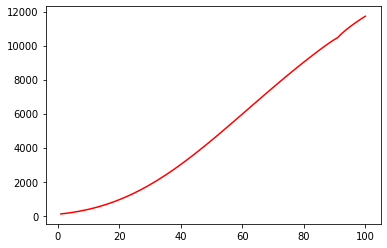

In [40]:
plt.plot(df_results0["YNET"],'r')
plt.show()

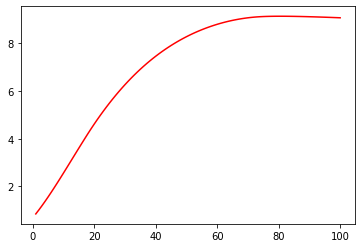

In [42]:
plt.plot(df_results0["TATM"],'r')
plt.show()

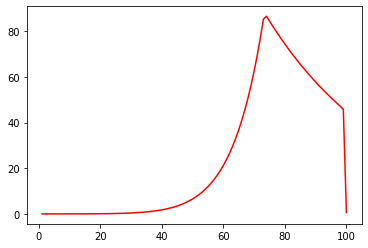

In [46]:
plt.plot(df_results0["PHOTEL"],'r')
plt.show()

In [49]:
# define upper bound on carbon price based on prelim computation
def cpriceBounds(model,t):
    if t <= params['tnopol'] : # Period before which no emissions controls base
        return (-np.inf,max(df_results0["PHOTEL"][t],params["cpricebase"]))
    else:
        return (-np.inf,np.inf) 

In [57]:
dicemodel0.CPRICE[10].bounds

(None, None)

In [51]:
dicemodel = diceModel2016(**params)

In [59]:
dicemodel.CPRICE.bounds = cpriceBounds

In [61]:
dicemodel.CPRICE[2].bounds

(None, None)

In [ ]:
# A reprendre ici : introduction d'une borne dans le modèle pour CPRICE

In [64]:
# Optimal scenario
params["ifopt"] = 1
df_results = pd.DataFrame(index = sorted(params["l"].keys())) # create a pandas dataframe to store the results

In [65]:
dicemodel = diceModel2016(**params) # model setup
    

# solve the model
results = solver.solve(dicemodel)

# Sanity check
if (results.solver.status != po.SolverStatus.ok):
    print('Check solver not ok ?')
if (results.solver.termination_condition != po.TerminationCondition.optimal):  
    print('Check solver optimality ?')

#  Value of the utility function for the solution
print('Optimal solution value for utility :', dicemodel.OBJ())

# store the results
createColumn('MIU',dicemodel.MIU,df_results)
createColumn('FORC',dicemodel.FORC,df_results)
createColumn('TATM',dicemodel.TATM,df_results)
createColumn('TOCEAN',dicemodel.TOCEAN,df_results)
createColumn('MAT',dicemodel.MAT,df_results)
createColumn('MU',dicemodel.MU,df_results)
createColumn('ML',dicemodel.ML,df_results)
createColumn('E',dicemodel.E,df_results)
createColumn('EIND',dicemodel.EIND,df_results)
createColumn('C',dicemodel.C,df_results)
createColumn('K',dicemodel.K,df_results)
createColumn('CPC',dicemodel.CPC,df_results)
createColumn('I',dicemodel.I,df_results)
createColumn('S',dicemodel.S,df_results)
createColumn('RI',dicemodel.RI,df_results)
createColumn('Y',dicemodel.Y,df_results)
createColumn('YGROSS',dicemodel.YGROSS,df_results)
createColumn('YNET',dicemodel.YNET,df_results)
createColumn('DAMAGES',dicemodel.DAMAGES,df_results)
createColumn('DAMFRAC',dicemodel.DAMFRAC,df_results)
createColumn('ABATECOST',dicemodel.ABATECOST,df_results)
createColumn('MCABATE',dicemodel.MCABATE,df_results)
createColumn('CCA',dicemodel.CCA,df_results)
createColumn('CCATOT',dicemodel.CCATOT,df_results)
createColumn('PERIODU',dicemodel.PERIODU,df_results)
createColumn('CPRICE',dicemodel.CPRICE,df_results)
createColumn('CEMUTOTPER',dicemodel.CEMUTOTPER,df_results)

Optimal solution value for utility : 4516.777544297598


In [66]:
df_results.head()

,MIU,FORC,TATM,TOCEAN,MAT,MU,ML,E,EIND,C,...,YNET,DAMAGES,DAMFRAC,ABATECOST,MCABATE,CCA,CCATOT,PERIODU,CPRICE,CEMUTOTPER
1,0.030000,2.463396,0.850000,0.006800,851.000000,460.000000,1740.000000,38.340385,35.740385,77.636548,...,104.998084,0.179338,0.001705,0.000856,2.012596,400.000000,500.000000,0.450446,2.012596,3334.654595
2,0.187198,2.738731,1.016342,0.027880,891.331850,471.289302,1740.670698,35.433519,33.132519,92.861155,...,125.117190,0.305751,0.002438,0.107807,36.732495,448.745751,552.291850,0.491032,36.732495,3579.481519
3,0.211515,2.965471,1.184334,0.052592,925.071953,485.127681,1741.419438,37.209836,35.173451,109.777637,...,147.400240,0.489552,0.003310,0.158018,43.542929,493.934675,600.619072,0.528295,43.542929,3762.314769
4,0.237749,3.191155,1.353691,0.080885,959.898257,500.206778,1742.263950,38.663639,36.861438,128.413359,...,171.932009,0.746776,0.004325,0.226354,51.187930,541.907194,651.368985,0.562561,51.187930,3887.239315
5,0.265957,3.413895,1.523974,0.112705,995.483726,516.405212,1743.212778,39.751774,38.156826,148.790260,...,198.753751,1.095392,0.005481,0.317519,59.714533,592.181932,704.101716,0.594123,59.714533,3959.726535


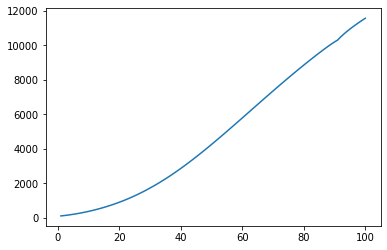

In [67]:
plt.plot(df_results["YNET"])
plt.show()

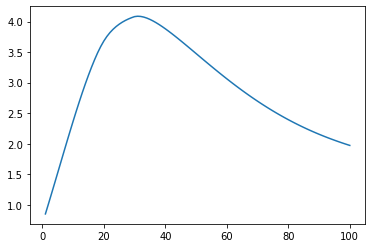

In [69]:
plt.plot(df_results["TATM"])
plt.show()

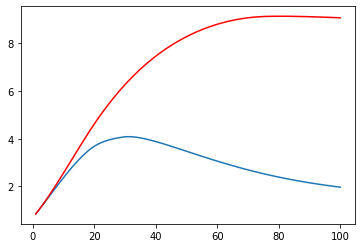

In [70]:
plt.plot(df_results["TATM"])
plt.plot(df_results0["TATM"],'r')
plt.show()

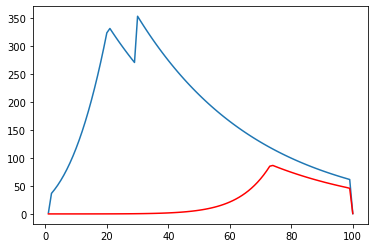

In [71]:
plt.plot(df_results["MCABATE"])
plt.plot(df_results0["MCABATE"],'r')
plt.show()

In [ ]:
# A faire : cout social du carbone

In [32]:
def solveModel(params,df_results,solver,ifopt=0) :
    """
    Solve the Dice model with optional optimization (ifopt = 1) 
    
    params : parameters for the model
    df_results : pandas dataframe to store the result
    solver : instance of a solver (e.g. ipopt)
    ifopt : optimization option
    
    """
    
    params["ifopt"] = ifopt
    
    if (ifopt == 0) : # baseline case
    
        params["a2"] = 0.0 # baseline run : no damage due to GHG
        
        dicemodel0 = diceModel2016(**params) # model setup
        
        results0 = solver.solve(dicemodel0) # solve the model without damage function
    
        # Sanity check
        if (results0.solver.status != po.SolverStatus.ok):
            print('Check solver not ok ?')
        if (results0.solver.termination_condition != po.TerminationCondition.optimal):  
            print('Check solver optimality ?')
    
        #  Value of the utility function for the solution
        print('Optimal solution value for intermediate computation :', dicemodel0.OBJ())

        # Hotelling price
        createColumn('PHOTEL',dicemodel0.CPRICE,df_results)
    
        params["a2"] = params["a20"] # restore the damage parameter
        
        # define upper bound on carbon price based on prelim computation
        def cpriceBounds(model,t):
            if t <= kwargs['tnopol'] : # Period before which no emissions controls base
                return (-np.inf,max(df_results["PHOTEL"][t],params["cpricebase"]))
            else:
                return (-np.inf,np.inf) 

    else :
        # no bounds on carbon price
        def cpriceBounds(model,t):
            return (-np.inf,np.inf) 

    
    # main solving
    
    dicemodel = diceModel2016(**params) # model setup
    
    dicemodel.CPRICE.bounds = cpriceBounds  
    
    # solve the model
    results = solver.solve(dicemodel)
        
    # Sanity check
    if (results.solver.status != po.SolverStatus.ok):
        print('Check solver not ok ?')
    if (results.solver.termination_condition != po.TerminationCondition.optimal):  
        print('Check solver optimality ?')

    #  Value of the utility function for the solution
    print('Optimal solution value for utility :', dicemodel.OBJ())
        
    # store the results
    createColumn('MIU',dicemodel.MIU,df_results)
    createColumn('FORC',dicemodel.FORC,df_results)
    createColumn('TATM',dicemodel.TATM,df_results)
    createColumn('TOCEAN',dicemodel.TOCEAN,df_results)
    createColumn('MAT',dicemodel.MAT,df_results)
    createColumn('MU',dicemodel.MU,df_results)
    createColumn('ML',dicemodel.ML,df_results)
    createColumn('E',dicemodel.E,df_results)
    createColumn('EIND',dicemodel.EIND,df_results)
    createColumn('C',dicemodel.C,df_results)
    createColumn('K',dicemodel.K,df_results)
    createColumn('CPC',dicemodel.CPC,df_results)
    createColumn('I',dicemodel.I,df_results)
    createColumn('S',dicemodel.S,df_results)
    createColumn('RI',dicemodel.RI,df_results)
    createColumn('Y',dicemodel.Y,df_results)
    createColumn('YGROSS',dicemodel.YGROSS,df_results)
    createColumn('YNET',dicemodel.YNET,df_results)
    createColumn('DAMAGES',dicemodel.DAMAGES,df_results)
    createColumn('DAMFRAC',dicemodel.DAMFRAC,df_results)
    createColumn('ABATECOST',dicemodel.ABATECOST,df_results)
    createColumn('MCABATE',dicemodel.MCABATE,df_results)
    createColumn('CCA',dicemodel.CCA,df_results)
    createColumn('CCATOT',dicemodel.CCATOT,df_results)
    createColumn('PERIODU',dicemodel.PERIODU,df_results)
    createColumn('CPRICE',dicemodel.CPRICE,df_results)
    createColumn('CEMUTOTPER',dicemodel.CEMUTOTPER,df_results)
    
    return results
    

In [33]:
solveModel(params,df_results,solver,ifopt=1)

Optimal solution value for utility : 4516.777544297598


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2493, 'Number of variables': 2700, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 15.940000057220459}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [40]:
solveModel(params,df_results,solver,ifopt=0)

Optimal solution value for intermediate computation : 4620.353570085999
Optimal solution value for utility : 4517.185979283772


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2493, 'Number of variables': 2700, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 4.572000026702881}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [72]:
# A faire : implémentation de la version R2